In [1]:
using Flux, Plots
using ChainRulesCore
using Statistics
using Random
using MDToolbox
using BenchmarkTools
using EzXML
using LinearAlgebra
using SparseArrays
using Dates
using Distributed
using FiniteDifferences

ENV["COLUMNS"] = 130

130

In [49]:
pdb_filepath = "./alanine-dipeptide-nowater.pdb"
traj_dir = "./sim_dihedral/"
ff_dir = "./sim_dihedral/"
njobs = 4

target_traj_path = "./target/sim_target.dcd"
target_ff_filepath = "./data/amber14/protein.ff14SB.xml" 

"./data/amber14/protein.ff14SB.xml"

In [3]:
slice = 1000 # データのスライス
#atom_list = [2 11] #距離を計算する原子のペア
atom_list = [5 17]

atom_pairs = []
for i in 1:length(atom_list)
    for j in i+1:length(atom_list)
        push!(atom_pairs, [atom_list[i] atom_list[j]])
    end
end

In [4]:
#pythonのmdtrajのインデックスに+1してる
phi_indices = [5, 7, 9, 15]   #二面角ϕ
psi_indices = [7, 9, 15, 17]  #二面角ψ

#xmlファイルでのatom type
phi_atom_type = ["C", "N", "CT", "C"]
psi_atom_type = ["N", "CT", "C", "N"]

4-element Vector{String}:
 "N"
 "CT"
 "C"
 "N"

In [5]:
function safe_acos(x::Float64)
    # xの値を[-1, 1]の範囲にクランプする
    return acos(clamp(x, -1.0, 1.0))
end

function _compute_dihedral(ta1::TrjArray{T, U}, ta2::TrjArray{T, U}, ta3::TrjArray{T, U}, ta4::TrjArray{T, U})::Vector{T} where {T, U}
    nframe = ta1.nframe
    com1 = centerofmass(ta1, isweight=true)
    com2 = centerofmass(ta2, isweight=true)
    com3 = centerofmass(ta3, isweight=true)
    com4 = centerofmass(ta4, isweight=true)
    a = zeros(T, nframe)
    # Threads.@threads for iframe in 1:nframe
    for iframe in 1:nframe
        d1 = [com1.xyz[iframe, 1] - com2.xyz[iframe, 1]; com1.xyz[iframe, 2] - com2.xyz[iframe, 2]; com1.xyz[iframe, 3] - com2.xyz[iframe, 3]]
        d2 = [com3.xyz[iframe, 1] - com2.xyz[iframe, 1]; com3.xyz[iframe, 2] - com2.xyz[iframe, 2]; com3.xyz[iframe, 3] - com2.xyz[iframe, 3]]
        d3 = [com3.xyz[iframe, 1] - com4.xyz[iframe, 1]; com3.xyz[iframe, 2] - com4.xyz[iframe, 2]; com3.xyz[iframe, 3] - com4.xyz[iframe, 3]]
        m1 = cross(d1, d2)
        m2 = cross(d2, d3)
        a[iframe] = safe_acos(dot(m1, m2)/(norm(m1)*norm(m2)))
        rotdirection = dot(d2,cross(m1,m2))
        if rotdirection < zero(T)
            a[iframe] = -a[iframe]
        end
    end
    a .= (a ./ pi) .* T(180)
end

_compute_dihedral (generic function with 1 method)

In [6]:
top = readpdb(pdb_filepath)

ta = mdload(target_traj_path)
ta = ta[1:slice:end]

phi = _compute_dihedral(ta[:,phi_indices[1]], ta[:,phi_indices[2]], ta[:,phi_indices[3]], ta[:,phi_indices[4]]) * π / 180
psi = _compute_dihedral(ta[:,psi_indices[1]], ta[:,psi_indices[2]], ta[:,psi_indices[3]], ta[:,psi_indices[4]]) * π / 180
dihedral_target = hcat(phi, psi)
    
distance_target = []
for i in 1:length(atom_pairs)
    d = compute_distance(ta, atom_pairs[i]) ./ 10
    push!(distance_target, d)
end
distance_target = hcat(distance_target...)

45471361×1 Matrix{Float64}:
 0.4268419276015334
 0.43465308537784475
 0.4223546078231715
 0.4033360378363695
 0.3916488676883441
 0.40480922869684666
 0.4091039980583634
 0.43084321113444013
 0.42385806532109827
 0.4267487739176584
 0.4138759514746101
 0.4337364890719971
 0.4392606885608955
 ⋮
 0.42792475453129164
 0.4232650705114514
 0.4183954261986592
 0.418945975180906
 0.39776812011604096
 0.4203368400825843
 0.4161002517666744
 0.4244241989900327
 0.42711256867605385
 0.4512456200572048
 0.4389364782953743
 0.406801232329807

In [10]:
"""
    function calc_histogram(data::AbstractVector;
                            rng=nothing,
                            bin_width=0.005, # nm
                            nbin=nothing,
                            density::Bool=false,
                            weight::AbstractArray=ones(length(data)))

Calculate a histogram of the input data `data`.

# Arguments
- `data::AbstractVector`: Input data vector.
- `rng::Tuple{Real, Real}`: Range of values to consider for the histogram. If not provided, the minimum and maximum values of `data` will be used.
- `bin_width::Real=0.005`: Width of each histogram bin.
- `nbin::Integer`: Number of bins for the histogram. If not provided, it will be automatically calculated based on `rng` and `bin_width`.
- `density::Bool=false`: If `true`, normalize the histogram to form a probability density.
- `weight::AbstractArray=[]`: Optional weights associated with each data point.

# Returns
- `hist::Array{Float64,1}`: Counts of data points in each bin.
- `bin_edge::Array{Float64,1}`: Edges of the bins.

# Examples
```julia-repl
julia> data = randn(1000)  # Generate random data
julia> hist, bin_edge = calc_histogram(data, rng=(-3, 3), bin_width=0.1, density=true)
```
"""
function calc_histogram(data::AbstractArray;
                        rng=nothing,
                        bin_width=0.005, # nm
                        nbin=nothing,
                        density::Bool=false,
                        weight::AbstractArray=ones(length(data)))
    
    # If range is not specified, use the range of the data
    if rng == nothing
        rng = (minimum(data), maximum(data))
    end
    # If data falls outside the specified range, ignore it
    data = filter(x -> rng[1] <= x && x <= rng[2], data)
    
    # If nbin is not specified, calculate it based on the bin width
    if nbin == nothing
        nbin = ceil(Int, (rng[2] - rng[1]) / bin_width)
    else
        # Recalculate bin width based on nbin
        bin_width = (rng[2] - rng[1]) / nbin
    end
    
    # Initialize histogram bins
    hist = zeros(Float64, nbin)
    
    # Calculate bin edges
    bin_edge = range(rng[1], rng[2], nbin+1) |> Vector
    
    # Calculate bin centers
    bin_center = (bin_edge[1:end-1] + bin_edge[2:end]) / 2

    min_value = minimum(data)
    # Fill histogram bins
    for (val, w) in zip(data, weight)
        #bin_index = argmin(abs.(bin_center .- val))
        bin_index = min(floor(Int, (val - min_value) / bin_width) + 1, nbin)    
        hist[bin_index] += w
    end
    
    # Normalize by total weight if density is true
    if density
        total_weight = sum(weight)
        hist ./= total_weight
    end
    
    return hist, bin_edge, rng
end

calc_histogram

In [11]:
function calc_histogram(data_k::Array{<:AbstractArray},
                        weight_k::Array{<:AbstractArray};
                        rng=nothing,
                        bin_width=0.005, # nm
                        nbin=nothing,
                        density::Bool=false)

    data = vcat(data_k...)
    weight = vcat(weight_k...)
    hist, bin_edge, _ = calc_histogram(data, rng=rng, bin_width=bin_width, nbin=nbin, density=density, weight=weight)
    
    return hist
end

function ChainRulesCore.rrule(::typeof(calc_histogram), 
                        data_k::Array{<:AbstractArray},
                        weight_k::Array{<:AbstractArray};
                        rng=nothing,
                        bin_width=0.005, # nm
                        nbin=nothing,
                        density::Bool=false)

    data = vcat(data_k...)
    weight = vcat(weight_k...)
    hist, bin_edge, rng = calc_histogram(data, rng=rng, bin_width=bin_width, nbin=nbin, density=density, weight=weight)
    K = length(data_k)
    N_k = Array{Int}(undef, K)
    for k in 1:K
        N_k[k] = size(data_k[k], 1)
    end
    function calc_histogram_pullback(dP)
        dweight = similar(weight)
        dweight .= 0.0

        bin_center = (bin_edge[1:end-1] + bin_edge[2:end]) / 2
        #println(bin_center)
        #println(length(dweight))
        min_value = minimum(data)
        for i in 1:length(dweight)
            #bin_index = argmin(abs.(bin_center .- data[i]))
            bin_index = min(floor(Int, (data[i] - min_value) / bin_width) + 1, nbin)
            dweight[i] += 1.0 * dP[bin_index]
        end

        #println(dweight)
        if density
            dweight = dweight ./ sum(weight)
        end
        
        dweight_k = similar(weight_k)

        istart = 1
        for i in 1:length(data_k)
            iend = istart + N_k[i] - 1
            dweight_k[i] = dweight[istart:iend]
            istart = iend + 1
        end
        
        return NoTangent(), NoTangent(), dweight_k, NoTangent(), NoTangent(), NoTangent(), NoTangent()
    end

    return hist, calc_histogram_pullback
end

 31.142221 seconds (409.32 M allocations: 6.781 GiB, 1.18% gc time, 0.47% compilation time)


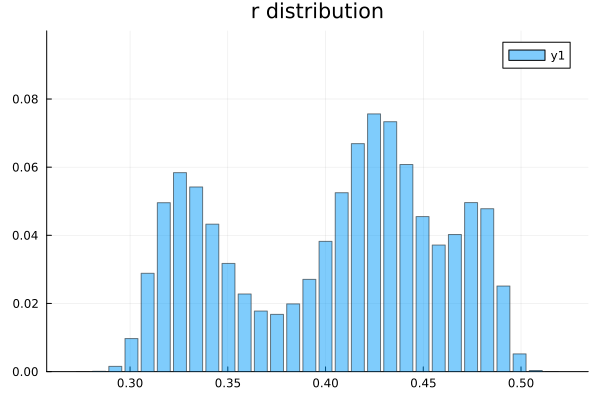

In [12]:
nbin = 30
data = distance_target
@time hist, bin_edge, rng = calc_histogram(data, nbin=nbin, density=true)
bin_center = (bin_edge[1:end-1] .+ bin_edge[2:end]) ./ 2
bar(bin_center, hist, width=1, alpha=0.5 ,title="r distribution", ylim=(0, 0.1))

In [13]:
#input traj

dihedral_k = Array{Array{Float64}}(undef, njobs) # 二面角ϕ,ψの値
distance_k = Array{Array{Float64}}(undef, njobs) # 二つの原子間の距離

for i in 1:njobs
    traj_filepath = joinpath(traj_dir, "sim_$(i)/traj_$(i).dcd")
    ta = mdload(traj_filepath, top=top)
    ta = ta[1:slice:end]

    phi = compute_dihedral(ta[:,phi_indices[1]], ta[:,phi_indices[2]], ta[:,phi_indices[3]], ta[:,phi_indices[4]]) * π / 180
    psi = compute_dihedral(ta[:,psi_indices[1]], ta[:,psi_indices[2]], ta[:,psi_indices[3]], ta[:,psi_indices[4]]) * π / 180
    dihedral_k[i] = hcat(phi, psi)

    distance = []
    for i in 1:length(atom_pairs)
        d = compute_distance(ta, atom_pairs[i]) ./ 10
        push!(distance, d)
    end
    distance_k[i] = hcat(distance...)
end

In [ ]:
#input traj
estimated_dir = "estimated_dihedral"

traj_filepath = joinpath(estimated_dir, "estimated_dihedral.dcd") 
ta = mdload(traj_filepath, top=top)[1:slice:end]

phi = compute_dihedral(ta[:,phi_indices[1]], ta[:,phi_indices[2]], ta[:,phi_indices[3]], ta[:,phi_indices[4]]) * π / 180
psi = compute_dihedral(ta[:,psi_indices[1]], ta[:,psi_indices[2]], ta[:,psi_indices[3]], ta[:,psi_indices[4]]) * π / 180
dihedral_estimated = hcat(phi, psi)
distance = []
for k in 1:length(atom_pairs)
    d = compute_distance(ta, atom_pairs[k]) ./ 10
    push!(distance, d)
end
distance_estimated = hcat(distance...)

## ターゲットのヒストグラムとの比較

In [ ]:
using Statistics, StatsBase, Plots

# KLダイバージェンスの計算
function kl_divergence(p::Vector{Float64}, q::Vector{Float64})
    mask = (p .> 0) .& (q .> 0)  # 0 にならないようにマスク
    return sum(p[mask] .* log.(p[mask] ./ q[mask]))
end

# JSD の計算
function js_divergence(p::Vector{Float64}, q::Vector{Float64})
    p = p / sum(p)  # 正規化（確率分布にする）
    q = q / sum(q)
    m = (p + q) / 2
    return 0.5 * kl_divergence(p, m) + 0.5 * kl_divergence(q, m)
end

# 2つのデータセットのヒストグラムを計算し、JSD を求める関数
function histogram_js_divergence(data1::Vector{Float64}, data2::Vector{Float64}; bins=20)
    # ヒストグラムの計算
    hist1 = fit(Histogram, data1, range(minimum(vcat(data1, data2)), maximum(vcat(data1, data2)), length=bins+1))
    hist2 = fit(Histogram, data2, range(minimum(vcat(data1, data2)), maximum(vcat(data1, data2)), length=bins+1))

    # 各ビンの確率分布を計算（正規化）
    p = hist1.weights ./ sum(hist1.weights)
    q = hist2.weights ./ sum(hist2.weights)

    # JSD の計算
    return js_divergence(p, q)
end

# 2つのランダムデータセットを作成
using Random
Random.seed!(123)

data1 = randn(1000)          # 標準正規分布
data2 = randn(1000) .+ 1.0   # 平均を 1 ずらした正規分布

# JSD の計算
jsd_value = histogram_js_divergence(data1, data2, bins=30)

println("Jensen-Shannon ダイバージェンス: ", jsd_value)

# ヒストグラムの描画
histogram(data1, bins=30, alpha=0.5, label="Data 1", normalize=true, color=:blue)
histogram!(data2, bins=30, alpha=0.5, label="Data 2", normalize=true, color=:red)
title!("Histogram Comparison of Two Distributions")
xlabel!("Value")
ylabel!("Probability Density")


In [ ]:
nbin = 30
data = distance_target
@time hist, bin_edge, rng = calc_histogram(data, nbin=nbin, density=true)
bin_center = (bin_edge[1:end-1] .+ bin_edge[2:end]) ./ 2
bar(bin_center, hist, width=1, label="target", alpha=0.5  )

data = distance_k[1]
@time hist = calc_histogram(data, rng=rng, nbin=nbin, density=true)
bar!(bin_center, hist, width=1, label="current", alpha=0.5, ylim=(0, 0.15))

plot!(#title="MCMC-sampled pair distances", 
    xlabel="Pair distance r [nm]",
    ylabel="Frequency", size=(400,300), dpi=900, legend=:topleft, framestyle=:box)

In [ ]:
data_target = distance_target
data_current = distance_k[1]
@show jsd = histogram_js_divergence(data_target, data_current, bins=30)

In [ ]:
nbin = 30
data = distance_target
@time hist, bin_edge, rng = calc_histogram(data, nbin=nbin, density=true)
bin_center = (bin_edge[1:end-1] .+ bin_edge[2:end]) ./ 2
bar(bin_center, hist, width=1, label="target", alpha=0.5)

data = distance_estimated
@time hist = calc_histogram(data, rng=rng, nbin=nbin, density=true)
bar!(bin_center, hist, width=1, label="estimated", alpha=0.5, ylim=(0, 0.15))

plot!(#title="MCMC-sampled pair distances", 
    xlabel="Pair distance r [nm]",
    ylabel="Frequency", size=(400,300), dpi=900, legend=:topleft, framestyle=:box)

In [ ]:
data_target = distance_target
data_estimated = distance_estimated
@show jsd = histogram_js_divergence(data_target, data_estimated, bins=30)

In [ ]:
using Plots
using Statistics  # 標準偏差やその他統計量のために使用

# 2Dカーネル密度推定とPMFを計算する関数
function calculate_pmf(x_data::Vector{<:Real}, y_data::Vector{<:Real}, grid_size::Int=100)
    # グリッドの生成
    x_grid = range(-π, stop=π, length=grid_size)
    y_grid = range(-π, stop=π, length=grid_size)

    # カーネル密度推定のバンド幅（スコットのルールを使用）
    #hx = 1.06 * std(x_data) * length(x_data)^(-1/5)  # xのバンド幅
    #hy = 1.06 * std(y_data) * length(y_data)^(-1/5)  # yのバンド幅

    hx = 0.5 * std(x_data) * length(x_data)^(-1/5)  # xのバンド幅
    hy = 0.5 * std(y_data) * length(y_data)^(-1/5)  # yのバンド幅
    # カーネル関数（ガウスカーネル）
    function gaussian_kernel(u)
        return exp(-0.5 * u^2) / sqrt(2 * π)
    end

    # カーネル密度推定の計算
    density = zeros(grid_size, grid_size)
    for i in 1:grid_size
        for j in 1:grid_size
            xi, yj = x_grid[i], y_grid[j]
            sum_k = 0.0
            for k in 1:length(x_data)
                sum_k += gaussian_kernel((xi - x_data[k]) / hx) * gaussian_kernel((yj - y_data[k]) / hy)
            end
            density[i, j] = sum_k / (length(x_data) * hx * hy)
        end
    end

    return x_grid, y_grid, density
end

# PMFの等高線プロットを作成
function plot_pmf_contour(x_grid, y_grid, pmf; title="PMF")
    # カラーマップの設定：閾値以上を白に設定
    
    # viridisの色を手動で指定
    viridis_colors = [
        RGB(0.267, 0.004, 0.329),
        RGB(0.283, 0.141, 0.458),
        RGB(0.254, 0.265, 0.530),
        RGB(0.207, 0.372, 0.553),
        RGB(0.164, 0.471, 0.558),
        RGB(0.128, 0.567, 0.551),
        RGB(0.136, 0.659, 0.517),
        RGB(0.267, 0.749, 0.441),
        RGB(0.478, 0.821, 0.318),
        RGB(0.741, 0.873, 0.150),
        RGB(0.993, 0.906, 0.144)
    ]
    
    # 最後に白色を追加
    extended_colors = vcat(viridis_colors, [RGB(1.0, 1.0, 1.0)])
    
    # カスタムカラーマップを作成
    extended_cmap = cgrad(extended_colors)
    
    # このカラーマップを使ってプロット
    # 例: contourf(x_grid, y_grid, data, color=extended_cmap)
    
    x_grid = x_grid .* 180 ./ π
    y_grid = y_grid .* 180 ./ π
    
    # カラーマップの範囲を設定
    threshold = 1e-8
    log_pmf = -log10.(pmf.+threshold)
    clims = (minimum(log_pmf), threshold)
    contourf(x_grid, y_grid, log_pmf, color=extended_cmap, colorbar=true, levels=10, dpi=900)
    xlabel!("Phi")
    ylabel!("Psi")
    title!(title)
end

In [ ]:
#　targetのpmf
# データの準備
x_data = dihedral_target[1:5:end, 2]
y_data = dihedral_target[1:5:end, 1]

# PMFの計算
x_grid, y_grid, pmf = calculate_pmf(x_data, y_data)
plot_pmf_contour(x_grid, y_grid, pmf)

In [ ]:
# 学習前のpmf
# データの準備
x_data = dihedral_k[1][1:5:end, 2]
y_data = dihedral_k[1][1:5:end, 1]

# PMFの計算
x_grid, y_grid, pmf = calculate_pmf(x_data, y_data)
plot_pmf_contour(x_grid, y_grid, pmf)

In [ ]:
# 学習後のpmf
# データの準備
x_data = dihedral_estimated[1:5:end, 2]
y_data = dihedral_estimated[1:5:end, 1]

# PMFの計算
x_grid, y_grid, pmf = calculate_pmf(x_data, y_data)
plot_pmf_contour(x_grid, y_grid, pmf)

In [ ]:
# pmfのjs_divergenceの計算
function kl_divergence(P::AbstractArray, Q::AbstractArray)
    return sum(P .* log.(P ./ Q))
end

function js_divergence(P::AbstractArray, Q::AbstractArray)
    M = 0.5 .* (P .+ Q)
    return 0.5 * kl_divergence(P, M) + 0.5 * kl_divergence(Q, M)
end

In [ ]:
# データの準備
x_data = dihedral_target[1:5:end, 2]
y_data = dihedral_target[1:5:end, 1]
# PMFの計算
x_grid, y_grid, pmf_target = calculate_pmf(x_data, y_data)

# データの準備
x_data = dihedral_k[1][1:5:end, 2]
y_data = dihedral_k[1][1:5:end, 1]
# PMFの計算
x_grid, y_grid, pmf_1 = calculate_pmf(x_data, y_data)

# データの準備
x_data = dihedral_estimated[1:5:end, 2]
y_data = dihedral_estimated[1:5:end, 1]
println(length(x_data))
# PMFの計算
x_grid, y_grid, pmf_estimated = calculate_pmf(x_data, y_data)

ε = 1e-12
pmf_target .= pmf_target .+ ε
pmf_1 .= pmf_1 .+ ε
pmf_estimated .= pmf_estimated .+ ε

pmf_target .= pmf_target ./ sum(pmf_target)
pmf_1 .= pmf_1 ./ sum(pmf_1)
pmf_estimated .= pmf_estimated ./ sum(pmf_estimated)